In [299]:
import pandas as pd
import os
import glob
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from plotnine import ggplot, geom_point, aes, scale_color_brewer, ggtitle, labs
from sklearn.preprocessing import StandardScaler

In [300]:
def plot_dendrogram(model, plot_title, linkage, affinity, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    figure(figsize=(30, 28))
    plt.title(plot_title)

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xticks(fontsize=13)
    plt.show()
    plt.savefig(f"../figures/cancer_cohort_{plot_title}_linkage_{linkage}_affinity_{affinity}.png")

def save_clustered_datafiles(model, data, cancer_type, distance_threshold, linkage, affinity):
    os.makedirs("../data/processed_data/hierarchically_clustered_mutations/", exist_ok=True)
    threshold_dir = f"../data/processed_data/hierarchically_clustered_mutations/{cancer_type}/linkage_{linkage}_affinity_" \
                    f"{affinity}/dist_thresh_{distance_threshold}"
    os.makedirs(threshold_dir,
                exist_ok=True)
    for idx, label in enumerate(np.unique(model.labels_)):
        patient_cluster = data.loc[model.labels_ == label]
        patient_cluster.to_csv(f"{threshold_dir}/C{idx}.csv")
        patient_cluster.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_C{idx}.csv")

    data.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_all.csv")


def cluster_data_and_display_clustering(distance_threshold, mutations_df, plot_title,
                                        save_clusters=False, affinity="euclidean",
                                        affinity_matrix=None, linkage="ward", no_labels=False):
    model = AgglomerativeClustering(n_clusters=None,
                                    distance_threshold=distance_threshold,
                                    linkage=linkage)
    if (affinity == "euclidean"):
        model = model.fit(mutations_df)
    elif (affinity == "pearson"):
        try:
            model = model.fit(affinity_matrix)
        except:
            print("affinity matrix musn't be None when affinity = 1-pearson")
    plot_dendrogram(model,
                    plot_title,
                    linkage,
                    affinity,
                    truncate_mode="level",
                    p=100,
                    no_labels=no_labels,
                    color_threshold=distance_threshold,
                    above_threshold_color="black",
                    labels = mutations_df.index.to_numpy())
    if (save_clusters):
        save_clustered_datafiles(model, mutations_df, plot_title, distance_threshold,
                                 linkage, affinity)
        
def get_per_cohort_mutations(cancer_cohort):
    binned_mutation_files = glob.glob(f'../data/processed_data/per_patient_mutations/{cancer_cohort}/binned_mutations*')
    chr_keep = pd.read_csv("../data/processed_data/chr_keep.csv")
    df = pd.DataFrame(columns=chr_keep["chr"].to_numpy())

    for file in binned_mutation_files:
        patient_id = file.split("_")[-1].split(".")[0]
        patient_mutations = pd.read_csv(file)['x']
        df.loc[patient_id] = patient_mutations.values

    agg_mutation_df = pd.read_csv("../data/processed_data/mut_count_data.csv", index_col=0)
    regions_to_consider = agg_mutation_df.loc[~agg_mutation_df.isna().any(axis=1)].index.values
    df = df.loc[:, regions_to_consider]
    return df

def group_donors_by_subtype(mutation_df, annotation_df):
    mutation_df.index = mutation_df.index.to_series().map(
                                                           annotation_df.to_dict()["subtype"]
                                                        )
    return(mutation_df)

def create_cohort_df(grouped_donor_dfs):
    grouped_donor_dfs = pd.concat(grouped_donor_dfs)
    return(grouped_donor_dfs.reset_index(names="subtype"))

def reduce_mutation_dims(df, method, n_components, scale=True):
    if (method == "PCA"):
        model = PCA(n_components=n_components)
    elif (method == "TSNE"):
        model = TSNE(n_components=n_components)
    elif(method == "UMAP"):
        model = umap.UMAP(n_components=n_components, random_state=1)
    
    df = df.drop("subtype", axis=1)
#     df = np.log(df / np.sum(df, axis=1) + 1)
    if (scale):
        df = StandardScaler().fit_transform(df)
#         df = (df - np.mean(df)) / np.std(df)
#         print(df)
#     print(np.sum(df, axis=0))
#     print((np.std(df) == 1.0).all())
#     print(df.shape)
    df_reduced = model.fit_transform(df)
    return([model, df_reduced])

def plot_reduced_dim_mutations(reduced_dim_data, model, components_to_plot, 
                               mut_counts, plot_title, subtypes):
    df = pd.DataFrame({"dim1": reduced_dim_data[:, 0], 
                       "dim2": reduced_dim_data[:, 1],
                       "subtype":subtypes,
                       "mut_counts": mut_counts})
    if (2 in components_to_plot):
        df["dim3"] = reduced_dim_data[:, 2]

    p = (
        ggplot(df, aes(components_to_plot[0], components_to_plot[1], shape='subtype', 
                color=np.log(mut_counts)))
         + geom_point(size=3)
         + ggtitle(plot_title) 
         + labs(color="mutation counts")
    )
    return(p)

/home/mdanb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


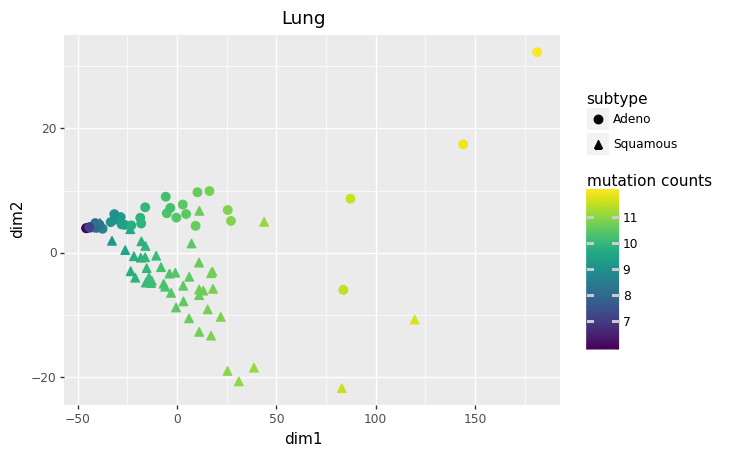

<ggplot: (8785517042923)>

In [319]:
# Lung
LUAD_US = get_per_cohort_mutations("LUAD-US")
LUSC_US = get_per_cohort_mutations("LUSC-US")
LUAD_US_annotation = pd.DataFrame(["Adeno"] * len(LUAD_US.index), index=LUAD_US.index,
                                 columns = ["subtype"])
LUSC_US_annotation = pd.DataFrame(["Squamous"] * len(LUSC_US.index), index=LUSC_US.index,
                                 columns = ["subtype"])

lung_adeno = group_donors_by_subtype(LUAD_US, LUAD_US_annotation)
lung_squamous = group_donors_by_subtype(LUSC_US, LUSC_US_annotation)
lung = create_cohort_df([lung_adeno, lung_squamous])
model, reduced_dim_data = reduce_mutation_dims(lung, "PCA", 2, True)
p = plot_reduced_dim_mutations(reduced_dim_data, 
                               model, 
                               ["dim1", "dim2"], 
                               np.sum(lung, axis=1), 
                               "Lung", 
                               lung["subtype"])
p
# lung

In [374]:
n=10

In [371]:
stds = np.std(lung_adeno)
largest_variance_feat_idxs = np.argsort(stds)[::-1]
top = lung_adeno.iloc[:, largest_variance_feat_idxs].iloc[:, 0:n]

In [376]:
np.std(top.iloc[:, 0:10])

chr19.28    52.885159
chr5.162    51.716681
chr5.163    49.793746
chr11.40    47.575291
chr2.123    47.235759
chr8.47     46.749195
chr13.53    46.555637
chr5.27     46.151955
chr7.143    46.118024
chr8.81     45.191727
dtype: float64

In [356]:
np.sort(np.std(top, axis=0))

AxisError: axis -1 is out of bounds for array of dimension 0

In [342]:
lung_adeno

,chr1.5,chr1.6,chr1.7,chr1.8,chr1.9,chr1.11,chr1.12,chr1.15,chr1.16,chr1.19,...,chr9.123,chr9.124,chr9.125,chr9.126,chr9.127,chr9.131,chr9.132,chr9.133,chr9.135,chr9.137
Adeno,0,0,0,1,1,0,2,1,0,0,...,1,2,1,3,0,1,1,0,1,1
Adeno,22,25,1,13,7,3,8,13,9,8,...,4,3,3,6,6,2,6,3,17,4
Adeno,1,3,1,1,1,4,2,0,2,0,...,1,2,1,3,1,1,2,2,0,0
Adeno,29,35,14,19,6,5,14,15,18,19,...,13,11,6,14,8,10,11,7,21,11
Adeno,2,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,2,0,1
Adeno,37,30,10,8,4,4,7,18,8,14,...,12,7,12,3,4,3,6,8,10,15
Adeno,6,0,3,4,0,1,1,1,1,2,...,0,5,2,18,16,1,3,0,3,1
Adeno,16,12,6,8,3,5,7,5,4,20,...,5,4,1,6,4,5,7,4,14,4
Adeno,45,53,22,31,15,13,28,22,18,52,...,25,26,21,23,16,25,18,22,41,12
Adeno,1,4,1,2,1,0,1,0,2,1,...,1,2,3,1,0,1,1,2,0,1


In [155]:
# df = StandardScaler().fit_transform(lung)

In [5]:
# cluster_data_and_display_clustering(2, LUAD_US, "LUAD_US", False,
#                                     affinity="pearson", affinity_matrix=
#                                     1 - np.corrcoef(LUAD_US),
#                                     linkage="average")

In [512]:
# # UMAP
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(df)
# df = pd.DataFrame({"dim1": embedding[:, 0], "dim2": embedding[:, 1], "subtype":df.index})

In [302]:
# # PCA
# pca = PCA(n_components=2)
# df_for_pca = df.T
# # df_for_pca = np.log(df_for_pca / np.sum(df_for_pca, axis=0) + 1)
# df_for_pca = (df_for_pca - np.mean(df_for_pca)) / np.std(df_for_pca)
# model = pca.fit(df_for_pca)
# df_pca = pd.DataFrame({"dim1": model.components_[0, :], 
#                        "dim2": model.components_[1, :], 
#                        "subtype":df_for_pca.columns,
#                        "mut_counts": mut_counts})
# (ggplot(df_pca, aes('dim1', 'dim2', shape='subtype', 
#                     color=np.log(mut_counts)))
#  + geom_point(size=3)
#  + ggtitle("Lung") 
#  + labs(color="mutation counts"))
# #  + scale_color_brewer(type="qual", palette="Set1")

In [9]:
PBCA_DE = get_per_cancer_mutations("PBCA-DE")
icgc_specimen_df = pd.read_csv("specimen.PBCA-DE.tsv.gz", sep="\t")
icgc_specimen_df = icgc_specimen_df[icgc_specimen_df["icgc_donor_id"].isin(
                                                   PBCA_DE.index.to_numpy())]
astrocytoma_donor_ids = pd.unique(icgc_specimen_df[icgc_specimen_df["tumour_histological_type"] 
                                  == "9421/1"]["icgc_donor_id"])

In [91]:
astrocytoma_df = icgc_specimen_df[icgc_specimen_df["icgc_donor_id"].isin(
                                                            astrocytoma_donor_ids)]
pd.unique(astrocytoma_df["tumour_histological_type"])

array(['9421/1', nan], dtype=object)

In [50]:
medulloblastoma_df = PBCA_DE[~PBCA_DE.index.isin(astrocytoma_donor_ids)]

In [43]:
# donor_and_histological_type.groupby(['icgc_donor_id','tumour_histological_type']).size().reset_index().rename(columns={0:'count'})

In [44]:
# pd.value_counts(icgc_specimen_df["tumour_histological_type"])

In [51]:
desmoplastic_medullo_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9471/3"]["icgc_donor_id"])
largecell_medullo_dIDs = pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9474/3"]["icgc_donor_id"])

medullo_NOS_dIDs =  pd.unique(icgc_specimen_df[icgc_specimen_df[
                                                    "tumour_histological_type"] == 
                                                    "9470/3"]["icgc_donor_id"])

In [94]:
print(len(desmoplastic_medullo_dIDs))
print(len(largecell_medullo_dIDs))
print(len(medullo_NOS_dIDs))

21
27
93


In [55]:
desmoplastic_map = medulloblastoma_df.loc[desmoplastic_medullo_dIDs].index.to_series()
desmoplastic_map[:] = "Desmoplastic"
desmoplastic_map

largecell_map = medulloblastoma_df.loc[largecell_medullo_dIDs].index.to_series()
largecell_map[:] = "Large Cell"
largecell_map

medullo_NOS_map = medulloblastoma_df.loc[medullo_NOS_dIDs].index.to_series()
medullo_NOS_map[:] = "Medullo NOS"
medullo_NOS_map

index_to_subtype_map = pd.concat((desmoplastic_map, largecell_map, medullo_NOS_map))

In [24]:
donor_to_subtype_LUAD_US = LUAD_US.index.to_series().map(lung_donors_to_subtype.to_dict()["subtype"])
LUAD_US.index = donor_to_subtype_LUAD_US
LUAD_US.index = ["Adeno"] * len(LUAD_US.index)
donor_to_subtype_LUSC_US = LUSC_US.index.to_series().map(lung_donors_to_subtype.to_dict()["subtype"])
LUSC_US.index = ["Squamous"] * len(LUSC_US.index)
df = pd.concat((LUSC_US, LUAD_US))

In [402]:
# df = pd.DataFrame({"dim1": df.iloc[:, 0], "dim2": df.iloc[:, 1], "subtype":LUAD_US.index})

In [444]:
# (ggplot(df, aes('dim1', 'dim2', color='subtype'))
#  + geom_point(size=3)
#  + scale_color_brewer(type="qual", palette="Set1")
#  + ggtitle("Lung"))